Check at which  ra,dec are located the  BDBS survey DECam imaging . We found that the proposalId = 2015A-0322  corresponds to BDBS. Possibly there may be other associated project Ids - this is the first pass to find out the ra,dec, and develop a pipeline. We check the ra,dec against the MAF simulated LSST Sky, and pull the regions with lowest density. 

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.table import Column
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.table import hstack
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

We selected all imaging data that has:
*dtpropid ILIKE '%2015A-0322%'
* prodtype = 'image'
* proctype = 'InstCal' 
* prodtype = 'image'

(resulting in 757 rows) 

    SELECT *  FROM voi.siap WHERE (dtpropid ILIKE '%2015A-0322%'   AND prodtype='image'  AND proctype = 'InstCal') LIMIT 50000



In [4]:
# read in the results of VO table ... 
fname = 'rows_as_votable_1513641281_48.vot.xml'  # only imaging 
from astropy.io.votable import parse_single_table
table = parse_single_table(fname)
bdbs = table.to_table()

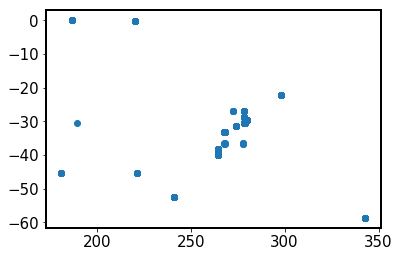

In [5]:
# plot the ra,dec of each BDBS field 
plt.scatter(bdbs['ra'].data, bdbs['dec'].data)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


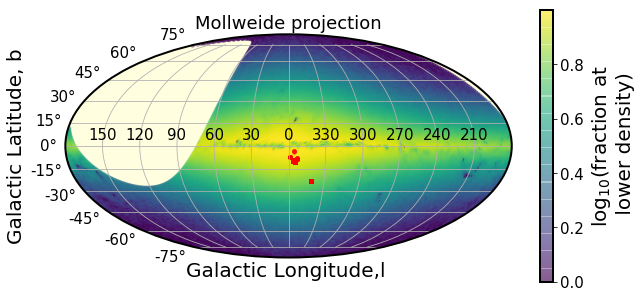

In [82]:
# Overplot on MAF density data... 
# Load up the data, copy the keys into variables
data = np.load('../raw_data/catalogs/starDensity_r_nside_64.npz')

# the data consists of 
# data['starDensity'],  expressed as stars / sq. deg  ,  per pixel, per magnitude
# data['bins'], defining the magnitude ranges for each of the 65 magnitude bins 
# data['overMaxMask'], which tells where there are more than 1e6 stars 

# Cumulative number counts, units of stars/sq deg. Array at healpix locations
starDensity = data['starDensity'].copy()
# magnitude bins 
bins = data['bins'].copy()
# pixels where there were so many  (1e6 ) stars some were skipped
mask = data['overMaxMask'].copy()

# select only bins up to 24.5  - then selecting the final bin will 
# give us the source count up to depth of 24.5 mag 
bright_mags, = np.where(bins<24.5)
faintest_mag_bin = bright_mags[-1]

# Since the data is already cumulative, just choose the  last bin: 
# this will have the number of stars up to the faintest magnitude 
# bin in a given  healpixel 
starDensity_lt_245 = data['starDensity'][:,faintest_mag_bin]

# Generate the ra, dec array from healpy
nside = hp.npix2nside(np.size(mask))
lat,ra = hp.pix2ang(nside, np.arange(np.size(mask)))
dec = np.pi/2-lat

# only select those healpixels for which we have any simulation data ...
m = starDensity_lt_245 > 0

density = starDensity_lt_245[m]
ra = ra[m]
dec = dec[m]

# For each pixel calculate how many pixels have a higher or equal density 
N_px_greater  = np.zeros_like(density)
for i in range(len(density)):
    N_px_greater[i]=np.sum(density>=density[i])
    
# calculate the fraction of pixels that have a higher density (by area)
frac_greater  = N_px_greater /  len(density)

# Make an AstroPy table with healpix data...

healpix_table = Table([density, ra,dec, N_px_greater, frac_greater], 
                      names=('source_density','ra_rad','dec_rad', 'N_px_greater', 
                             'frac_greater'))


# express pixel coordinates as SkyCoord object, 
healpix_coords = SkyCoord(ra,dec, frame='icrs', unit='rad')

# express the BDBS field coordinates as SkyCoord object ..
bdbs_coords = SkyCoord(ra = bdbs['ra'].data, dec = bdbs['dec'].data, 
                       unit='degree', frame='icrs')

#
# for plotting  in mollweide projection ... 
# 
# express the MAF healpixel coords in galactic 
# coords,  in degrees 
longitude = healpix_coords.galactic.l.deg
latitude  = healpix_coords.galactic.b.deg

# possibility to center the map on 0 or 180...
origin = 0
x = np.remainder(longitude+360-origin,360) # shift RA values
ind = x>180
x[ind] -=360    # scale conversion to [-180, 180]
x=-x    # reverse the scale: East to the left
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+origin,360)

# color by the fraction of pixels at greater density (or 1 - that)
z = frac_greater


# Plot in Mollweide projection the MAF densities 
# in Galactic coordinates 
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide', facecolor ='LightYellow')

# convert degrees to radians
imge = ax.scatter(np.radians(x),np.radians(latitude),  alpha=0.4,s=14, c=1-z)  

# also overplot the BDBS objects...
ax.scatter(bdbs_coords.galactic.l.rad, bdbs_coords.galactic.b.rad, 
           alpha=0.4, s=14, c = 'red')

ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
i += 1 
    
title='Mollweide projection'
ax.set_title(title)
xlabel='Galactic Longitude,l '
ylabel='Galactic Latitude, b'
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.grid(True)
#plt.legend(fontsize=14)
plt.colorbar(imge, label=r'$\log_{10}$'+'(fraction at\n lower density)')
#plt.savefig('Illustrate_density_mollw_galactic.png', bbox_inches='tight')

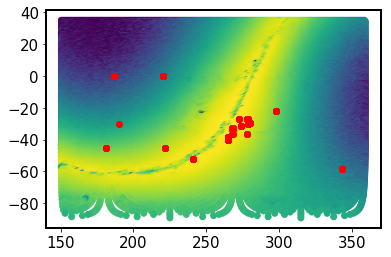

In [83]:
# plot the same , but just the small 
# part that corresponds to BDBS 
m1 = healpix_coords.ra.degree > 150
plt.scatter(healpix_coords.ra.degree[m1], healpix_coords.dec.degree[m1], c=1-z[m1])
plt.scatter(bdbs_coords.ra.degree, bdbs_coords.dec.degree, c='red')

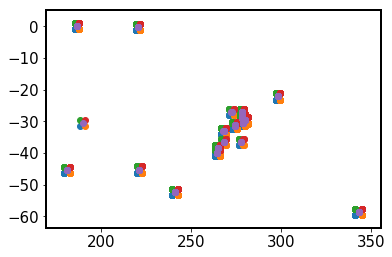

In [85]:
# We have the data for the center of the mosaic as well as the four corners...
for i in range(1,5):
    plt.scatter(bdbs_maf['corn'+str(i)+'ra'], bdbs_maf['corn'+str(i)+'dec'])
plt.scatter(bdbs_maf['ra'], bdbs_maf['dec'])

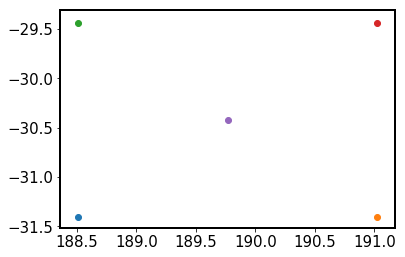

In [86]:
# The distance match is based on the two-dimensional distance 
for i in range(1,5):
    plt.scatter(bdbs_maf['corn'+str(i)+'ra'][0], bdbs_maf['corn'+str(i)+'dec'][0])
plt.scatter(bdbs_maf['ra'][0], bdbs_maf['dec'][0])

In [89]:
dx = bdbs_maf['ra'][0] - bdbs_maf['corn'+str(1)+'ra'][0]
dy = bdbs_maf['dec'][0] - bdbs_maf['corn'+str(1)+'dec'][0]
print(dx,dy)
# half of the diagonal in degrees ...
print('Good radius is', np.sqrt(dx**2.0 +  dy**2.0), ' degress')

# thus anything that I find  within that distance would be good as an 
# approximate measaure of  density in that BBDS field 

1.255519 0.978662
Good radius is 1.59188795762  degress


In [91]:
# Find the MAF-derived densties for the BDBS fields...
# coord1:  bdbs_coords
# coord2 : healpix_coords

idx, d2d, d3d = bdbs_coords.match_to_catalog_sky(healpix_coords)  

# stack the two catalogs 
bdbs_maf = hstack([bdbs, healpix_table[idx]])

# add column with distance to the nearest MAF pixel...
bdbs_maf['d2d_deg'] = d2d.degree

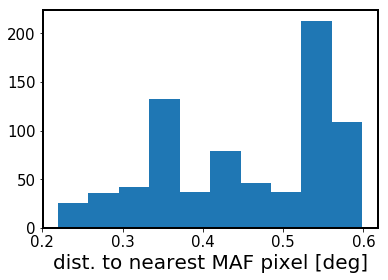

In [92]:
# So all nearest-match MAF pixels are within 
# the half-diagonal of the DECam image mosaic..
plt.hist(bdbs_maf['d2d_deg'])
plt.xlabel('dist. to nearest MAF pixel [deg]')

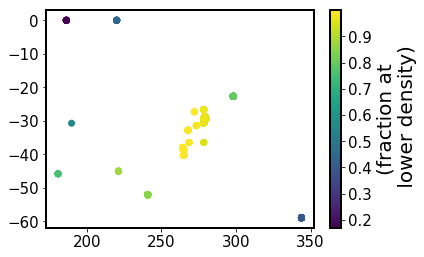

In [94]:
imge = plt.scatter(np.degrees(bdbs_maf['ra_rad']), np.degrees(bdbs_maf['dec_rad']),
            c = 1-bdbs_maf['frac_greater'])
plt.colorbar(imge, label='(fraction at\n lower density)')

In [96]:
bdbs_maf.sort('frac_greater')

In [174]:
# choose exposure to be above 90 sec...
mask_exp  = bdbs_maf['exposure'].data > 90 

# see what fractions are available...
np.unique(bdbs_maf[mask_exp]['frac_greater'])

0.000567244224422
0.000773514851485
0.00549195544554
0.00848287953795
0.0210653877888
0.0249329620462
0.0274597772277
0.0287231848185
0.0346276815182
0.0479063531353
0.146735767327


In [180]:

np.arange(5,175,20)

array([  5,  25,  45,  65,  85, 105, 125, 145, 165])

In [199]:
#bdbs_maf['dtnsanam']

In [219]:
#fig,ax = plt.subplots(1,1,figsize = (7,7))

dtnsanam_choose = {}
for fraction in np.unique(bdbs_maf['frac_greater']):
    mask1 = bdbs_maf['frac_greater'] == fraction
    
    mask2 = bdbs_maf['exposure'] > 100 
    mask3 = bdbs_maf['exposure'] < 130
    mask = mask1*mask2*mask3
    if np.sum(mask) > 1 : 
        dtnsanam_choose[fraction] = []
        print(fraction, np.sum(mask), np.unique(bdbs_maf['exposure'][mask]),
              )
        bdbs_select = bdbs_maf[mask]['dtnsanam'].data.data.astype(str)
        dtnsanam_choose[fraction].append(bdbs_select[:2])
    elif np.sum(mask1*mask2) > 1: 
        mask = mask1*mask2
        dtnsanam_choose[fraction] = []
        print(fraction, np.sum(mask), np.unique(bdbs_maf['exposure'][mask]))
        bdbs_select = bdbs_maf[mask]['dtnsanam'].data.data.astype(str)
        dtnsanam_choose[fraction].append(bdbs_select[:2])
    #print(fraction,np.unique(bdbs_maf[mask]['exposure']),'\n')
    #ax.hist(bdbs_maf[mask]['exposure'], bins=bins, histtype='step')    

0.000567244224422 4 exposure
--------
   120.0
0.000773514851485 16 exposure
--------
   120.0
0.00549195544554 4 exposure
--------
   120.0
0.00848287953795 12 exposure
--------
   120.0
0.0210653877888 16 exposure
--------
   120.0
0.0249329620462 12 exposure
--------
   120.0
0.0274597772277 4 exposure
--------
   120.0
0.0287231848185 17 exposure
--------
   120.0
0.0346276815182 16 exposure
--------
   120.0
0.0479063531353 4 exposure
--------
   120.0
0.146735767327 4 exposure
--------
   150.0
0.199231641914 74 exposure
--------
   120.0
0.60442450495 9 exposure
--------
   120.0


In [213]:
# I chose two fields per density, 
# at exposure longer than 70 sec 
dtnsanam_choose

{0.00056724422442244228: [array(['c4d_150803_044512_ori.fits', 'c4d_150803_044244_ori.fits'],
        dtype='<U26')],
 0.00077351485148514855: [array(['c4d_150803_040841_ori.fits', 'c4d_150803_041104_ori.fits'],
        dtype='<U26')],
 0.0054919554455445541: [array(['c4d_150803_043411_ori.fits', 'c4d_150803_043640_ori.fits'],
        dtype='<U26')],
 0.0084828795379537948: [array(['c4d_150803_052541_ori.fits', 'c4d_150803_052314_ori.fits'],
        dtype='<U26')],
 0.021065387788778877: [array(['c4d_150802_023108_ori.fits', 'c4d_150802_022843_ori.fits'],
        dtype='<U26')],
 0.024932962046204619: [array(['c4d_150802_032822_ori.fits', 'c4d_150802_032056_ori.fits'],
        dtype='<U26')],
 0.027459777227722772: [array(['c4d_150802_032555_ori.fits', 'c4d_150802_031605_ori.fits'],
        dtype='<U26')],
 0.028723184818481847: [array(['c4d_150802_034733_ori.fits', 'c4d_150803_023903_ori.fits'],
        dtype='<U26')],
 0.034627681518151814: [array(['c4d_150803_053916_ori.fits', 'c4d_

In [230]:
selected_names = []
for key in dtnsanam_choose.keys():
    selected_names.append(dtnsanam_choose[key][0])
selected_names = np.ravel(selected_names)

In [255]:
# Store info about the selected fields ...
select_rows = np.in1d(bdbs_maf['dtnsanam'].data.data.astype(str), selected_names)
print('We have selected ',np.sum(select_rows), ' rows')
cols = ['dtnsanam', 'reference', 'filter', 'exposure', 
        'ra','dec', 'source_density', 'frac_greater']
fname = 'Selected_BBDS_MAF_120-150s_13_densities.dat'

bdbs_maf_save = bdbs_maf[select_rows][cols]

x = len('http://nsaserver.sdm.noao.edu:7003/?fileRef=')
file_list = [name[x:] for name in bdbs_maf_save['reference'].data.data.astype(str)]

bdbs_maf_save['archive_file'] = file_list
bdbs_maf_save.write(fname, format='ascii', overwrite=True)
print('Saved as ', fname)

We have selected  26  rows
Saved as  Selected_BBDS_MAF_120-150s_13_densities.dat


In [259]:
bdbs_maf_save[['frac_greater', 'archive_file']].sort('archive_file')

In [260]:
bdbs_maf_save[['frac_greater', 'archive_file']]

frac_greater,archive_file
float64,str34
0.000567244224422,c4d_150803_044512_ooi_z_v1.fits.fz
0.000567244224422,c4d_150803_044244_ooi_z_v1.fits.fz
0.000773514851485,c4d_150803_040841_ooi_Y_v1.fits.fz
0.000773514851485,c4d_150803_041104_ooi_Y_v1.fits.fz
0.00549195544554,c4d_150803_043411_ooi_Y_v1.fits.fz
0.00549195544554,c4d_150803_043640_ooi_Y_v1.fits.fz
0.00848287953795,c4d_150803_052541_ooi_Y_v1.fits.fz
0.00848287953795,c4d_150803_052314_ooi_Y_v1.fits.fz
0.0210653877888,c4d_150802_023108_ooi_z_v1.fits.fz


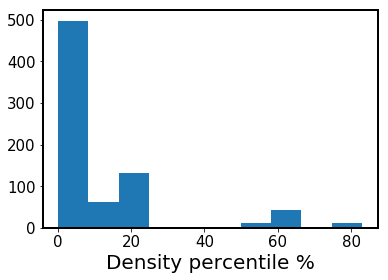

In [108]:
plt.hist(100*(bdbs_maf['frac_greater']))
plt.xlabel('Density percentile %')

In [109]:
# Pick eg. a 20-something percent region, so that we can quickly process, and 
# we know it will run successfully...
# Then we would run them in increasing order of density ... 
m = (0.2< bdbs_maf['frac_greater'])*(bdbs_maf['frac_greater'] < 0.25)
bdbs_maf[m]

md5sum,bandpass_id,dtacqnam,noao_id,corn1ra,dtpropid,pixflags,corn3ra,bunit,darkfil,obsmode,mimetype,corn4dec,obs_elev,corn2ra,disper,rawfile,survey,dttitle,corn1dec,proctype,depth_err,equinox,mjd_obs,dtutc,pldname,corn3dec,rsptgrp,seeing,bandpass_hilimit,nocslit,filtid,observat,naxis_length,depth,ha,plqname,filesize,prodtype,fk5coords,magzero,dqmask,filter,exposure,seqid,flatfil,reject,timesys,naxes,dtnsanam,zd,dtobserv,object,dtpiaffl,efftime,ra,dtsite,plver,obs_lat,dec,obs_long,dtpi,date_obs,airmass,rspgrp,radesys,frngfil,sflatfil,obstype,fits_extension,instrument,telescope,surveyid,reference,ds_ident,magerr,photclam,puplfil,photfwhm,astrmcat,corn4ra,bandpass_unit,sb_recno,pipeline,corn2dec,fits_data_product_id,biasfil,photbw,release_date,filename,bandpass_lolimit,prop_id,instrume,start_date,vo_id,nocssn,source_density,ra_rad,dec_rad,N_px_greater,frac_greater,d2d_deg
object,object,object,object,float64,object,object,float64,object,object,object,object,float64,float64,float64,object,object,object,object,float64,object,object,float64,float64,object,object,float64,object,float64,object,object,object,object,object,float64,float64,object,int32,object,object,float64,object,object,float64,object,object,object,object,int32,object,float64,object,object,object,float64,float64,object,object,float64,float64,float64,object,object,float64,object,object,object,object,object,int32,object,object,object,object,object,float64,float64,object,float64,object,float64,object,int32,object,float64,int32,object,float64,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64
3087d8e41cbbd73a90d2b97f9bc0e151,,/data_local/images/DTS/2015A-0322/DECam_00455148.fits.fz,richr,179.50446299999999,2015A-0322,unknown,179.50446299999999,adu,,imaging,image/fits,-44.416279000000003,2215.0,182.59072800000001,,,,,-46.375681999999998,InstCal,unknown,2000.0,57211.963453349999,2015-07-08 23:08:16,DEC15A_20150708_89083bd,-44.416279000000003,,--,unknown,,,CTIO,"24,4094",--,21.270958333333301,20150708,314112960,image,,25.940000000000001,,i DECam SDSS c0003 7835.0 1470.0,3.0,,DEC15A_20150708_89083bd-iF-20150708T200501_ci[N31],,UTC,2,c4d_150708_230816_ori.fits,22.550000000000001,NOAO,E5-A,,--,181.04808299999999,ct,V3.7,-30.166060000000002,-45.397139000000003,70.814890000000005,Rich,2015-07-08 23:07:22.369,1.0800000000000001,,ICRS,,,object,1,decam,ct4m,,http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_150708_230816_ooi_i_v1.fits.fz,,--,--,,--,,182.59072800000001,unknown,3281372,,-46.375681999999998,109314070,DEC15A_20150708_89083bd-Z-20150708T194157_ci[N31],--,2017-01-09,DEC15A_20150708_89083bd-i-20150708T230722_oi,unknown,2015A-0322,DECam,2015-07-08,rmrastro@us-vo.org,,58140.0,3.15490448687,-0.799080971598,9462.0,0.243966584158,0.435332500374
3e97bab29b1b7e352d770671f970ea55,,/data_local/images/DTS/2015A-0322/DECam_00455145.fits.fz,richr,179.50380799999999,2015A-0322,unknown,179.50380799999999,adu,,imaging,image/fits,-44.416721000000003,2215.0,182.590339,,,,,-46.376303,InstCal,unknown,2000.0,57211.962335819997,2015-07-08 23:06:41,DEC15A_20150708_89083bd,-44.416721000000003,,--,unknown,,,CTIO,"24,4094",--,20.949208333333299,20150708,313119360,image,,23.462,,u DECam c0006 3500.0 1000.0,10.0,,DEC15A_20150708_89083bd-uF-20150708T204006_ci[N31],,UTC,2,c4d_150708_230641_ori.fits,22.359999999999999,NOAO,E5-A,,--,181.04754199999999,ct,V3.7,-30.166060000000002,-45.397722000000002,70.814890000000005,Rich,2015-07-08 23:05:45.814,1.0800000000000001,,ICRS,,,object,1,decam,ct4m,,http://nsaserver.sdm.noao.edu:7003/?fileRef=c4d_150708_230641_ooi_u_v1.fits.fz,,--,--,,--,,182.590339,unknown,3282048,,-46.376303,109334085,DEC15A_20150708_89083bd-Z-20150708T194157_ci[N31],--,2017-01-09,DEC15A_20150708_89083bd-u-20150708T230545_oi,unknown,2015A-0322,DECam,2015-07-08,rmrastro@us-vo.org,,58140.0,3.15490448687,-0.799080971598,9462.0,0.243966584158,0.434640329332
6ee9ceffa8d33a789a6f44371735dd2d,,/data_local/images/DTS/2015A-0322/DECam_00455149.fits.fz,

In [232]:
#np.ravel(bdbs_maf.colnames)

In [233]:
#plt.hist(bdbs_maf[m]['exposure'])

In [158]:
# Well, here I see that these are very short exposures...
# Let's find out only the 'deeper' exposures...
m1 = bdbs_maf['exposure'] > 60

# within the 20-25% region ( we know that we can definitely work 
# in such densities ... ) 
m2 = (0.15< bdbs_maf['frac_greater'])*(bdbs_maf['frac_greater'] < 0.3)

# select exposure of 120 sec. .... 
m3 = bdbs_maf['exposure'] == 120 

# combine filters...
m = m1 * m2 *m3
bdbs_maf[['exposure', 'frac_greater', 'ra', 'dec', 'filter', 'magzero']][m]

exposure,frac_greater,ra,dec,filter,magzero
float64,float64,float64,float64,object,float64
120.0,0.199231641914,298.17087500000002,-22.146556,r DECam SDSS c0002 6415.0 1480.0,30.334
120.0,0.199231641914,298.169667,-22.147749999999998,g DECam SDSS c0001 4720.0 1520.0,29.933
120.0,0.199231641914,298.17179199999998,-22.145806,i DECam SDSS c0003 7835.0 1470.0,30.260000000000002
120.0,0.199231641914,298.1705,-22.147777999999999,g DECam SDSS c0001 4720.0 1520.0,29.751000000000001
120.0,0.199231641914,298.17000000000002,-22.147556000000002,r DECam SDSS c0002 6415.0 1480.0,30.119
120.0,0.199231641914,298.17108300000001,-22.146639,i DECam SDSS c0003 7835.0 1470.0,30.074000000000002
120.0,0.199231641914,298.16845799999999,-22.145416999999998,g DECam SDSS c0001 4720.0 1520.0,30.155999999999999
120.0,0.199231641914,298.16833300000002,-22.146528,r DECam SDSS c0002 6415.0 1480.0,30.463000000000001
120.0,0.199231641914,298.16841699999998,-22.146111000000001,i DECam SDSS c0003 7835.0 1470.0,30.379999999999999


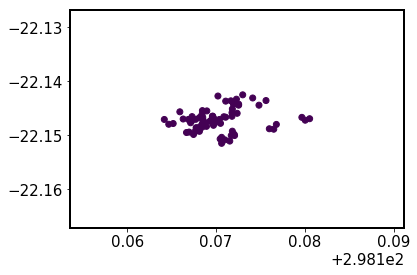

In [159]:
plt.scatter(bdbs_maf['ra'][m], bdbs_maf['dec'][m], c = bdbs_maf['frac_greater'][m])

In [125]:
# np.unique(bdbs_maf['frac_greater'][m])
# all are here at the same 'density' - 19.9% 

0.199231641914


In [ ]:
# Now to download  the needed imaging data from NOAO, 
# we would need to query the Archives 
# http://archive.noao.edu/tutorials/secure_get

# One way would be to abandon the constraint prodtype='image'  in the initial NOAO 
# query - this would provide us 
# three rows rather than one : wtmask,  instcal, and dqmap ,  per visit 

# we'd run it through the same selection as above, and 
# in the end save only the rows that we like as the votable
# scp this table to NCSA,  and run the processing  of these visits 
# 

In [160]:
# archive filenames to download ...
bdbs_maf[m][['dtnsanam', 'exposure']]

dtnsanam,exposure
object,float64
c4d_150929_024722_ori.fits,120.0
c4d_150929_024455_ori.fits,120.0
c4d_150929_024952_ori.fits,120.0
c4d_150929_033759_ori.fits,120.0
c4d_150929_034028_ori.fits,120.0
c4d_150929_034257_ori.fits,120.0
c4d_150929_233839_ori.fits,120.0
c4d_150929_234109_ori.fits,120.0
c4d_150929_234337_ori.fits,120.0


We selected  imaging ,wtmap and dqmasks :  
* dtpropid ILIKE '%2015A-0322%'
* proctype = 'InstCal' 

(resulting in 757*3 = 2271 rows) 

    SELECT *  FROM voi.siap WHERE (dtpropid ILIKE '%2015A-0322%' AND proctype = 'InstCal') LIMIT 50000




In [149]:
# from a file that has imaging, wtmap,  dqmask, select only desired rows ...
fname = 'rows_as_votable_1513648002_6339.vot.xml'  # imaging, dqmask ,wtmap 
table = parse_single_table(fname)
bdbs_all = table.to_table()

In [240]:
# Select only desired rows... should number  74 * 3 = 222 
#select = np.in1d(bdbs_all['dtnsanam'].data.data.astype(str), 
#                 bdbs_maf[m]['dtnsanam'].data.data.astype(str))

# Select only the two fields per density : 26 in total, 
# as defined above ( 120-150 sec exposure)

select = np.in1d(bdbs_all['dtnsanam'].data.data.astype(str), selected_names[::-1])

# thus there should be 3*26 ( dqmask+wtmap+instcal) 
assert np.sum(select) == 3*26

In [266]:
from astropy.table import join

In [268]:
join?

In [270]:
bdbs_all_merged = join(left=bdbs_all[select], right=bdbs_maf[['dtnsanam','frac_greater']], 
                   keys='dtnsanam')

In [311]:
# concatenate reference to just the filename
x = len('http://nsaserver.sdm.noao.edu:7003/?fileRef=')
file_list = [name[x:] for name in bdbs_all_merged['reference'].data.data.astype(str)]
bdbs_all_merged['archive_file']  = file_list

# concatenate full filter name to first letter...
f = [line[:1] for line in  bdbs_all_merged['filter'].data.data.astype(str)]
bdbs_all_merged['filter_short'] = f

# add visit number ....
x1 = len('/data_local/images/DTS/2015A-0322/DECam_00')
x2 = len('.fits.fz')
visit = [line[x1:-x2] for line in bdbs_all_merged['dtacqnam'].data.data.astype(str)]
bdbs_all_merged['visit'] = visit

# store as a simple text file ... 
fname = 'bbds_NOAO_download_votable_78_info.txt'
bdbs_all_merged[['archive_file','frac_greater',
                 'filter_short','exposure', 'visit']].write(fname, format='ascii',
                                                            overwrite=True   )

In [329]:
# Pull only the unique visits ....
visits, indices = np.unique(bdbs_all_merged['visit'].data.data, return_index=True)

fname = 'bbds_NOAO_download_votable_78_info_26_visits.txt'
bdbs_visits_used  = bdbs_all_merged['archive_file','frac_greater',
                 'filter_short','exposure', 'visit'][indices]
# and sort by densities... 
bdbs_visits_used.sort('frac_greater')
bdbs_visits_used.write(fname, format='ascii',   overwrite=True   )

In [328]:
bdbs_visits_used



archive_file,frac_greater,filter_short,exposure,visit
str34,float64,str1,float64,str6
c4d_150803_044512_oow_z_v1.fits.fz,0.000567244224422,z,120.0,461313
c4d_150803_044244_oow_z_v1.fits.fz,0.000567244224422,z,120.0,461312
c4d_150803_040841_oow_Y_v1.fits.fz,0.000773514851485,Y,120.0,461299
c4d_150803_041104_oow_Y_v1.fits.fz,0.000773514851485,Y,120.0,461300
c4d_150803_043411_ood_Y_v1.fits.fz,0.00549195544554,Y,120.0,461309
c4d_150803_043640_ood_Y_v1.fits.fz,0.00549195544554,Y,120.0,461310
c4d_150803_052541_ood_Y_v1.fits.fz,0.00848287953795,Y,120.0,461329
c4d_150803_052314_oow_Y_v1.fits.fz,0.00848287953795,Y,120.0,461328
c4d_150802_022843_ooi_i_v1.fits.fz,0.0210653877888,i,120.0,460436


In [301]:
#f

In [247]:
# save that list of archive filenames 
# as a VOTable to download 
# with secure get 
N = np.sum(select)
fname = 'bbds_NOAO_download_votable_'+str(N)+'.vot.xml'
bdbs_all[select].write(fname,format='votable',
                          overwrite=True)
print('We saved %d names to download as %s'%(N,fname))

We saved 78 names to download as bbds_NOAO_download_votable_78.vot.xml


Now first we need to scp the NCSA the `secure_get.sh`  script:
    
    scp secure_get.sh scichris@lsst-dev.ncsa.illinois.edu:/home/scichris/ 

Now scp to NCSA the VO Table with files to download : 
 
    scp bbds_NOAO_download_votable_78.vot.xml scichris@lsst-dev.ncsa.illinois.edu:/home/scichris/ 

In [264]:
x = len('http://nsaserver.sdm.noao.edu:7003/?fileRef=')
file_list = [name[x:] for name in bdbs_all[select]['reference'].data.data.astype(str)]

## NCSA processing of DECam BDBS files ... 

Now log onto the NCSA 

    ssh scichris@lsst-dev.ncsa.illinois.edu

Execute the NOAO download script : 
    
    ./secure_get.sh bbds_NOAO_download_votable_78.vot.xml
    
Once files are downloaded, move to appropriate directories :
    
    mkdir bbds_files
    cd bbds_files
    mkdir wtmap
    mkdir instcal
    mkdir dqmask
    cd ..
    mv  c4d*ooi*    bbds_files/instcal/
    mv  c4d*oow*    bbds_files/wtmap/
    mv  c4d*ood*    bbds_files/dqmask/
    
Setup the LSST tools : 
    
    source /ssd/lsstsw/stack/loadLSST.bash
    setup obs_decam
    
Make a directory for the output : 
    
    mkdir bbds_repo

Make a butler settings file : 
    
    echo lsst.obs.decam.DecamMapper > bbds_repo/_mapper
    
Ingest the images : 
    
    ingestImagesDecam.py bbds_repo/ bbds_files/instcal/*.fits.fz
    
[--> I get warnings here such as 
    
    ingest.parse WARN: Unable to find value for ccdnum (derived from CCDNUM)
    ingest.parse WARN: Unable to find value for ccd (derived from CCDNUM)
but it's not essential ... ]

Open a detached tmux session :
    
    tmux
    
In a detached session start the processing. I start from the lowest density, which should go smoothly...
    
    processCcd.py bbds_repo --rerun proc60g  --id visit=460468  -C config_processccd.py --clobber-config
    
[ but at the moment I get errors.. ] 

Detach from tmux  
 
    ctrl+B
    
    